In [28]:
%load_ext autoreload
%autoreload 2

from MyClassifier_13 import MyClassifier
import numpy as np
import requests, gzip, os, hashlib
import matplotlib.pyplot as plt

np.random.seed(1) # for reproducibility

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
### driver code
use_mnist = True # Set to True to use MNIST, False to use synthetic data (smaller and faster)

if use_mnist:
    # fetching the MNIST data

    ### change this line of code to put the data where you want it
    path = "./testing"
    os.makedirs(path, exist_ok=True)
    ###

    def fetch(url):
        fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
        if os.path.isfile(fp):
            with open(fp, "rb") as f:
                data = f.read()
        else:
            with open(fp, "wb") as f:
                data = requests.get(url).content
                f.write(data)
        return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

    y_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 784))
    s_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
    y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 784))
    s_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

    # taking only 1's and 7's
    y_train = y_train[(s_train == 1) | (s_train == 7)]
    s_train = s_train[(s_train == 1) | (s_train == 7)].astype(np.int8)
    y_test = y_test[(s_test == 1) | (s_test == 7)]
    s_test = s_test[(s_test == 1) | (s_test == 7)].astype(np.int8)

    # map 1's to s = 1 and 7's to s = -1
    s_train[s_train == 1] = 1
    s_train[s_train == 7] = -1
    s_test[s_test == 1] = 1
    s_test[s_test == 7] = -1

    N_train = 1500 # reduce training size so it completes faster
    training_indices = np.random.choice(range(y_train.shape[0]), size=N_train, replace=False)
    y_train = y_train[training_indices]
    s_train = s_train[training_indices]

else:
    # synthetic dataset
    def make_dataset(N):
        Y = np.concatenate((np.random.multivariate_normal(np.array([-1,1]), np.identity(2), N//2), np.random.multivariate_normal(np.array([1,-1]), np.identity(2), N//2)))
        S = np.concatenate((-np.ones(N//2, dtype=np.int8), np.ones(N//2, dtype=np.int8)))
        return (Y, S)

    N_train = 1000
    N_test = 1000

    y_train, s_train = make_dataset(N_train)
    y_test, s_test = make_dataset(N_test)


In [30]:
print(y_train.shape)
print(s_train.shape)
print(y_test.shape)
print(s_test.shape)

# check for roughly equal amounts of training samples per class
print()
print((s_train[s_train == 1]).shape)
print((s_train[s_train == -1]).shape)

(1500, 784)
(1500,)
(2163, 784)
(2163,)

(793,)
(707,)


In [31]:
# train all at once
model = MyClassifier(y_train.shape[1])
model.train(y_train, s_train)

In [32]:
# test
def percentage_correct(inferences, labels):
    N_test = inferences.shape[0]
    return 1/N_test * np.ones(N_test)@(labels == inferences)

inferences = model.test(y_test)
print(percentage_correct(inferences, s_test))

0.966250577901061


In [33]:
# train online
model = MyClassifier(y_train.shape[1])

for i in range(len(y_train)):
    model.sample_selection(y_train[i], s_train[i])
    model.train()

print("Used {} out of {} samples".format(model.y_train.shape[0], y_train.shape[0]))

Used 46 out of 1500 samples


In [34]:
# test
def percentage_correct(inferences, labels):
    N_test = inferences.shape[0]
    return 1/N_test * np.ones(N_test)@(labels == inferences)

inferences = model.test(y_test)
print(percentage_correct(inferences, s_test))


0.9838187702265347


In [35]:
def choose_data(y,s, ratio_to_use):
    # 
    N = y.shape[0]
    idxes = np.random.choice(N, int(N*ratio_to_use))
    y_select = np.take(y, idxes, axis=0)  
    s_select = np.take(s, idxes, axis=0)
    return y_select, s_select

In [36]:
percentage_list = [0.001,0.002,0.003, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
percentage_correct_list = []
for n in percentage_list:
    y_train_select, s_train_select = choose_data(y_train,s_train, n)
    # train all at once
    model = MyClassifier(y_train.shape[1])
    model.train(y_train_select, s_train_select)
    inferences = model.test(y_test)
    percentage_correct_list.append(percentage_correct(inferences, s_test))

Text(0, 0.5, 'Percentage of correct inference on test data (%)')

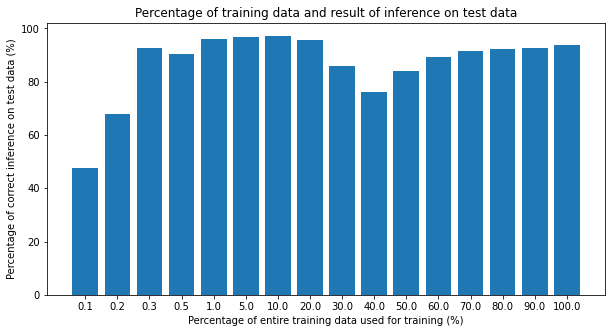

In [37]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.bar([str(p*100) for p in percentage_list], [p*100 for p in percentage_correct_list])
ax.set_title('Percentage of training data and result of inference on test data')
ax.set_xlabel('Percentage of entire training data used for training (%)')
ax.set_ylabel('Percentage of correct inference on test data (%)')
# Not sure what to make of these results; Is it overfitting at around 40% and then generalizing???

In [38]:
def show_test_result(i,ax):
    im = y_test[i].reshape(28,28)
    ax.imshow(im)
    if inferences[i] == 1:
        ax.set_title('1')
    elif inferences[i] == -1:
        ax.set_title('7')

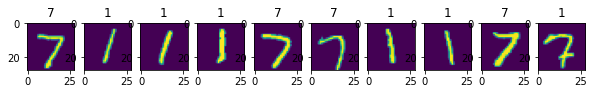

In [39]:
fig, axes = plt.subplots(1,10, figsize=(10,10))
for i, ax in enumerate(axes):
    show_test_result(i, ax)
    